In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit, KFold
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
pd.options.display.float_format = '{:,.3f}'.format

import matplotlib
font = {'family' : 'Arial', 'size'   : 12}
matplotlib.rc('font', **font)

In [3]:
def get_samples(vectors):
    return pd.read_pickle("../data/training/positive/mibig_bgcs_all.{}.pkl".format(vectors))

# Candidate classification: Multilabel and multiclass method evaluation

## Problem specification

Predict biosynthetic class (classes) of BGC candidates.

## Methods

### Multilabel approach

Assign a set of classes (labels) to each BGC candidate

Model output is a binary vector:

In [4]:
activity = pd.read_csv("../data/mibig/mibig_compounds.csv").set_index('contig_id')
activity = activity[activity['any_known_activity']]
activity.head()

,BGC_ID,num_compounds,compounds,num_activity,activity,any_known_activity,any_antibacterial,any_antifungal,any_antioxidant,any_antiviral,any_cytotoxic,any_inhibitor,any_other,any_pigment,any_siderophore,any_signalling,any_surfactant,any_unknown
contig_id,,,,,,,,,,,,,,,,,,
BGC0000001.1,BGC0000001,2,Abyssomicin C;Atrop-abyssomicin C,2,Antibacterial;Cytotoxic,True,1,0,0,0,1,0,0,0,0,0,0,0
BGC0000016.1,BGC0000016,1,Amphotericin B,1,Antifungal,True,0,1,0,0,0,0,0,0,0,0,0,0
BGC0000017.1,BGC0000017,2,Anatoxin-a;Homoanatoxin-a,1,Other,True,0,0,0,0,0,0,1,0,0,0,0,0
BGC0000023.1,BGC0000023,1,Aurafuron A,2,Antifungal;Cytotoxic,True,0,1,0,0,1,0,0,0,0,0,0,0
BGC0000024.1,BGC0000024,1,aureothin,4,Antibacterial;Antifungal;Cytotoxic;Other,True,1,1,0,0,1,0,1,0,0,0,0,0


antibacterial    180
cytotoxic        142
inhibitor         81
other             72
antifungal        71
unknown           45
signalling        15
siderophore       11
surfactant         8
antioxidant        8
pigment            2
antiviral          1
dtype: int64

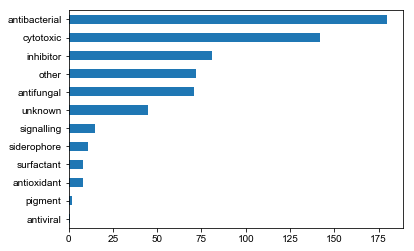

In [5]:
all_labels = activity[[c for c in activity.columns if c.startswith('any_') and c != 'any_known_activity']]
all_labels = all_labels.rename(columns={c: c.replace('any_','') for c in all_labels.columns})
label_counts = all_labels.sum().sort_values()
label_counts.plot.barh()
label_counts[::-1]

In [6]:
labels = all_labels[['antibacterial','cytotoxic','inhibitor','antifungal']]
labels.head()

,antibacterial,cytotoxic,inhibitor,antifungal
contig_id,,,,
BGC0000001.1,1,1,0,0
BGC0000016.1,0,0,0,1
BGC0000017.1,0,0,0,0
BGC0000023.1,0,1,0,1
BGC0000024.1,1,1,0,1


## Input data

### Domain set

Binary vector of top 2000 pfam IDs, 1 = pfam is present in sequence, 0 = pfam is not present

In [7]:
get_samples('domain_set').head(3)

pfam_id,PF00004,PF00005,PF00006,PF00009,PF00010,PF00011,PF00012,PF00013,PF00015,PF00022,...,PF17387,PF17389,PF17390,PF17391,PF17392,PF17414,PF17425,PF17508,PF17584,PF17608
contig_id,,,,,,,,,,,,,,,,,,,,,
BGC0000001.1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000002.1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000003.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Classification methods

- K Nearest Neighbors
- Random Forest

## Validation methods


- Train/test split validation
- N-Fold Crossvalidation

# Results

In [8]:
def get_sample_responses(vectors, responses):
    samples = get_samples(vectors)
    responses = responses.loc[samples.index].dropna()
    samples = samples.loc[responses.index]
    return samples, responses
    

# Multilabel classification

In [14]:
ml_samples, ml_responses = get_sample_responses('domain_set', labels)
len(ml_samples)

402

In [15]:
major_bgc_ids = pd.Series(ml_samples.index).apply(lambda contig_id: contig_id.split('.')[0])
major_to_minor_ids = pd.Series(ml_samples.index, index=major_bgc_ids)
major_to_minor_ids.head()

contig_id
BGC0000001    BGC0000001.1
BGC0000016    BGC0000016.1
BGC0000017    BGC0000017.1
BGC0000023    BGC0000023.1
BGC0000024    BGC0000024.1
Name: contig_id, dtype: object

In [16]:
unique_major_ids = major_bgc_ids.unique()
len(unique_major_ids)

370

### Cross-validation

In [17]:
def create_model():
    return RandomForestClassifier(n_estimators=100)

In [19]:
splitter = KFold(n_splits=5, shuffle=True, random_state=0)

scores = []
accuracies = []
for id_train_idx, id_test_idx in splitter.split(unique_major_ids):
    train_major_ids, test_major_ids = unique_major_ids[id_train_idx], unique_major_ids[id_test_idx]
    train_minor_ids, test_minor_ids = major_to_minor_ids.loc[train_major_ids], major_to_minor_ids.loc[test_major_ids]
    X_train, X_test = ml_samples.loc[train_minor_ids].values, ml_samples.loc[test_minor_ids].values
    y_train, y_test = ml_responses.loc[train_minor_ids].values, ml_responses.loc[test_minor_ids].values
    print('Train:', len(X_train), 'Test:', len(X_test))
    model = create_model()
    # fitting the model
    model.fit(X_train, y_train)
    # predict the response
    pred = (model.predict(X_test) >= 0.5).astype(np.int)
    aucs = metrics.roc_auc_score(y_test, pred, average=None)
    precisions = metrics.precision_score(y_test, pred, average=None)
    recalls = metrics.recall_score(y_test, pred, average=None)
    accuracy = metrics.accuracy_score(y_test, pred)
    accuracies.append(accuracy)
    scores += [{'Precision': p, 'Recall': r, 'AUC': a, 'Class': c, 'Samples': int(sum(ml_responses[c]))} for p,r,a,c in zip(precisions, recalls, aucs, ml_responses.columns)]

scores = pd.DataFrame(scores).groupby('Class').mean().sort_values('Samples', ascending=False)
print('Accuracy (exact match)', np.mean(accuracies))
print(scores.mean())

Train: 308 Test: 94
Train: 325 Test: 77


/Users/prihodad/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train: 326 Test: 76
Train: 323 Test: 79
Train: 326 Test: 76
Accuracy (exact match) 0.31521218515279215
AUC           0.603
Precision     0.536
Recall        0.310
Samples     118.000
dtype: float64


/Users/prihodad/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
scores

,AUC,Precision,Recall,Samples
Class,,,,
antibacterial,0.629,0.615,0.508,180
cytotoxic,0.706,0.694,0.542,140
inhibitor,0.545,0.473,0.115,81
antifungal,0.532,0.360,0.073,71


In [23]:
merged_scores = scores[['Samples','AUC','Precision','Recall']]
merged_scores = merged_scores.sort_values(by='Samples', ascending=False)
merged_scores.index = [v.capitalize() for v in merged_scores.index]
merged_scores = merged_scores.append(pd.Series(merged_scores.mean(), name='Average'))
merged_scores

,Samples,AUC,Precision,Recall
Antibacterial,180.000,0.629,0.615,0.508
Cytotoxic,140.000,0.706,0.694,0.542
Inhibitor,81.000,0.545,0.473,0.115
Antifungal,71.000,0.532,0.360,0.073
Average,118.000,0.603,0.536,0.310


# Candidate activity prediction

In [11]:
model = RandomForestClassifier(n_estimators=100)
model.fit(ml_samples.values, ml_responses.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
columns = np.array([l.replace('any_','').capitalize() for l in ml_responses.columns])

In [25]:
def read_vectors_to_predict(path, train_columns):
    vectors = pd.read_pickle(path)
    for col in set(train_columns).difference(vectors.columns):
        vectors[col] = 0
    return vectors[train_columns.values]

In [26]:
model_path = '128lstm-100pfamdim-8pfamiter-posweighted-neg-10k-fpr2'

In [27]:
candidates = read_vectors_to_predict("../data/bacteria/candidates/{}/domain_set.pkl".format(model_path), ml_samples.columns)
candidates.head()

pfam_id,PF00004,PF00005,PF00006,PF00009,PF00010,PF00011,PF00012,PF00013,PF00015,PF00022,...,PF17387,PF17389,PF17390,PF17391,PF17392,PF17414,PF17425,PF17508,PF17584,PF17608
contig_id,,,,,,,,,,,,,,,,,,,,,
000749207dc6a8d25a7b67282a2fe375,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
00244b39ef89b1f18ccf4da018657383,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
0024a1c619f0dba6e8420c60b6c815e7,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
002d6748dad4145b1f09ca9dc93ead44,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
003041bd79286a337bdd94c332198c33,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000


In [33]:
results = np.array([r[:,1] for r in model.predict_proba(candidates.values)]).transpose()
predictions = pd.DataFrame(results, index=candidates.index, columns=columns)
predictions['classes'] = [';'.join(columns[x >= 0.5]) for x in results]
predictions.head()

,Antibacterial,Cytotoxic,Inhibitor,Antifungal,classes
contig_id,,,,,
000749207dc6a8d25a7b67282a2fe375,0.410,0.070,0.250,0.060,
00244b39ef89b1f18ccf4da018657383,0.584,0.170,0.296,0.114,Antibacterial
0024a1c619f0dba6e8420c60b6c815e7,0.710,0.120,0.040,0.120,Antibacterial
002d6748dad4145b1f09ca9dc93ead44,0.442,0.150,0.358,0.162,
003041bd79286a337bdd94c332198c33,0.560,0.070,0.310,0.100,Antibacterial


In [34]:
predictions.to_csv('../data/bacteria/candidates/{}/classes/activity-domain_set-rf/classes.csv'.format(model_path))